In [ ]:
# 📦 Load required libraries
library(ggplot2)
library(dplyr)
library(tidyr)
library(readr)

library(ggsignif) # for manual/custom significance annotations
library(ggpubr) # optional: auto stats + brackets
library(DESeq2)
library(biomaRt)


In [3]:
# 📂 Load DESeq2 object and extract expression matrix
# Load your full DESeq2 object
dds <- readRDS("/home/layanomics/CrispAstro-Seq/04_differential_expression/results/dds.rds")

# Apply rlog transformation for plotting
rld <- rlog(dds) # if this takes too long, we can use vst() instead

# Extract expression matrix
rlog_mat <- assay(rld)

# Preview
head(rlog_mat)


,SRR16497780,SRR16497781,SRR16497782,SRR16497783,SRR16497784,SRR16497785
ENSG00000000003,6.732041,7.493482,7.5374610,7.525570,6.9312687,7.649414
ENSG00000000419,8.577470,8.028663,8.0476608,8.092422,8.0892290,7.934652
ENSG00000000457,6.390858,6.417857,6.6224204,6.518834,6.4732112,6.295328
ENSG00000000460,5.555361,5.614041,6.4281263,5.864583,6.3104438,6.257015
ENSG00000000938,2.499513,2.668011,1.8579731,2.095319,2.1786605,1.821903
ENSG00000000971,1.270580,1.239476,0.9427786,1.254846,0.9606411,1.094606


In [4]:
# 🔎 Get Ensembl IDs for genes of interest (GFAP, C3, NES)

# Connect to Ensembl (GRCh38)
ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl", version = 105) # GENCODE v38 = Ensembl 105

# List of gene symbols you want
genes <- c("GFAP", "C3", "NES")

# Get mapping
gene_map <- getBM(
    attributes = c("ensembl_gene_id", "hgnc_symbol"),
    filters = "hgnc_symbol",
    values = genes,
    mart = ensembl
)

print(gene_map)


  ensembl_gene_id hgnc_symbol
1 ENSG00000125730          C3
2 ENSG00000131095        GFAP
3 ENSG00000132688         NES


In [5]:
# 🧬 Create tidy data frame for each gene

make_plot_df <- function(gene_id, gene_label, dds, rlog_mat) {
    data.frame(
        sample_id = colnames(rlog_mat),
        expression = as.numeric(rlog_mat[gene_id, , drop = TRUE]),
        genotype = colData(dds)$condition,
        gene = gene_label
    )
}

# Generate data frames for each gene
plot_dfs <- gene_map %>%
    rowwise() %>%
    mutate(data = list(make_plot_df(ensembl_gene_id, hgnc_symbol, dds, rlog_mat))) %>%
    pull(data)

# Combine into one tidy frame
expression_df <- bind_rows(plot_dfs)

# Preview
head(expression_df)


,sample_id,expression,genotype,gene
,<chr>,<dbl>,<fct>,<chr>
1,SRR16497780,6.904729,WT,C3
2,SRR16497781,7.157741,R270X,C3
3,SRR16497782,7.736175,WT,C3
4,SRR16497783,7.735525,R270X,C3
5,SRR16497784,6.555582,WT,C3
6,SRR16497785,7.858381,R270X,C3


In [6]:
# Define gene ID for Nestin
nes_ensg_id <- "ENSG00000132688"

if (!(nes_ensg_id %in% rownames(dds))) {
    stop("Gene not found.")
}


nes_counts <- as.numeric(counts(dds, normalized = TRUE)[nes_ensg_id, ])
sample_data <- as.data.frame(colData(dds))

# Combine into data frame
plot_data <- data.frame(
    condition = sample_data$condition,
    expression = nes_counts
)


# Normalize to WT mean
wt_mean <- mean(plot_data$expression[plot_data$condition == "WT"])
plot_data$relative_expression <- plot_data$expression / wt_mean

# Compute group means and SEMs
summary_data <- plot_data %>%
    group_by(condition) %>%
    summarise(
        mean_expression = mean(relative_expression),
        se_expression = sd(relative_expression) / sqrt(n())
    ) %>%
    mutate(
        x_numeric = as.numeric(factor(condition)),
        y_top = mean_expression + se_expression
    )



# Run t-test
t_test_result <- t.test(relative_expression ~ condition, data = plot_data)
p_value <- t_test_result$p.value
significance_label <- ifelse(p_value < 0.001, "***",
    ifelse(p_value < 0.05, "*", "ns")
)


In [7]:
plot_data


condition,expression,relative_expression
<fct>,<dbl>,<dbl>
WT,25509.170,1.2628282
R270X,4656.406,0.2305148
WT,12071.181,0.5975823
R270X,16375.737,0.8106788
WT,23019.743,1.1395895
R270X,10592.192,0.5243651


In [8]:
library(rlang)

geom_top_errorbar <- function(data,
                              x = "x_numeric",
                              y = "mean_expression",
                              yend = "y_top",
                              whisker_width = 0.4,
                              linewidth = 0.6,
                              color = "black") {
    x_sym <- sym(x)
    y_sym <- sym(y)
    yend_sym <- sym(yend)

    list(
        # Vertical line
        geom_segment(
            data = data,
            mapping = aes(x = !!x_sym, xend = !!x_sym, y = !!y_sym, yend = !!yend_sym),
            linewidth = linewidth,
            color = color,
            inherit.aes = FALSE
        ),
        # Top whisker
        geom_segment(
            data = data,
            mapping = aes(
                x = !!x_sym - whisker_width / 2,
                xend = !!x_sym + whisker_width / 2,
                y = !!yend_sym, yend = !!yend_sym
            ),
            linewidth = linewidth,
            color = color,
            inherit.aes = FALSE
        )
    )
}



Attaching package: ‘rlang’


The following object is masked from ‘package:Biobase’:

    exprs




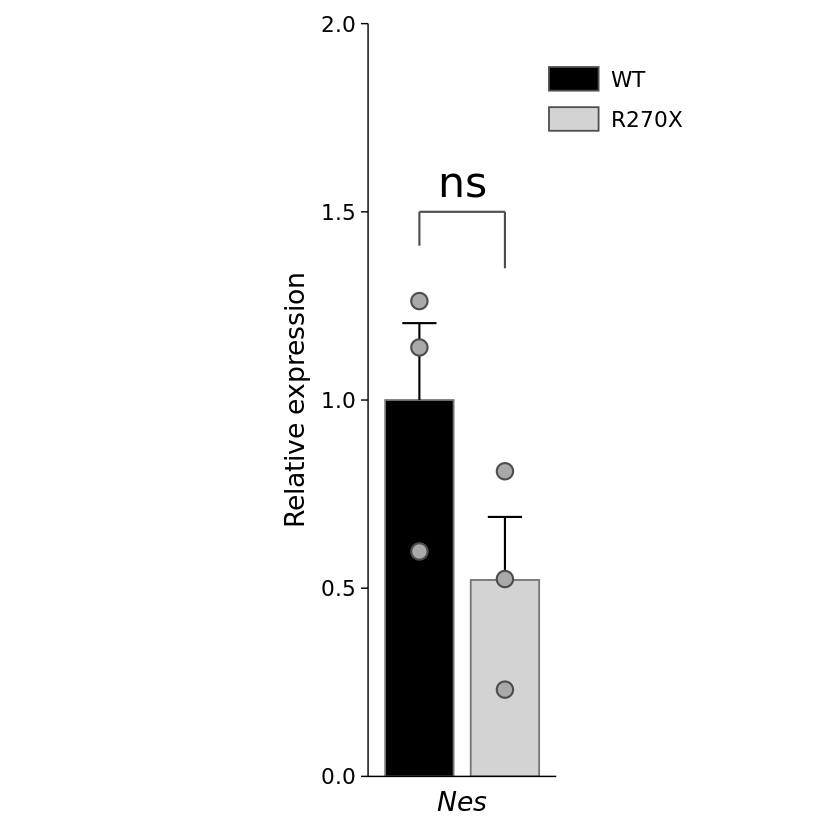

In [9]:
y_sig <- 1.5 # move this OUTSIDE the ggplot

p_nes <- ggplot(plot_data, aes(x = condition, y = relative_expression)) +
    geom_bar(
        data = summary_data,
        aes(x = condition, y = mean_expression, fill = condition),
        stat = "identity",
        width = 0.8,
        color = "grey45",
        linewidth = 0.5,
    ) +
    geom_top_errorbar(summary_data) +
    geom_point(
        color = "grey30", # fixed black outline
        fill = "darkgrey", # fixed grey fill
        shape = 21, size = 4.0, stroke = 0.9
    ) +
    scale_fill_manual(values = c("WT" = "black", "R270X" = "lightgray")) +

    # significance label and lines (inside the ggplot chain)
    annotate("text", x = 1.5, y = y_sig + 0.08, label = significance_label, size = 9) +
    annotate("segment", x = 1, xend = 2, y = y_sig, yend = y_sig, color = "grey30", linewidth = 0.6) +
    annotate("segment", x = 1, xend = 1, y = y_sig, yend = y_sig - 0.09, color = "grey30", linewidth = 0.6) +
    annotate("segment", x = 2, xend = 2, y = y_sig, yend = y_sig - 0.15, color = "grey30", linewidth = 0.6) +
    labs(x = expression(italic("Nes")), y = "Relative expression") +
    scale_y_continuous(limits = c(0, 2.0), breaks = seq(0, 2, 0.5), expand = c(0, 0)) +
    theme_minimal(base_size = 14) +
    theme(
        axis.line = element_line(color = "black", linewidth = 0.4),
        panel.grid = element_blank(),
        panel.background = element_rect(fill = "white", color = NA),
        plot.background = element_rect(fill = "white", color = NA),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_line(color = "black", linewidth = 0.4),
        axis.ticks.length.y = unit(0.15, "cm"),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 13, color = "black"),
        axis.title.x = element_text(face = "italic", size = 16, color = "black", margin = margin(t = 5)),
        axis.title.y = element_text(size = 16, margin = margin(r = 10), color = "black"),
        legend.position = "inside",
        legend.position.inside = c(1.3, 0.9),
        legend.title = element_blank(),
        legend.text = element_text(size = 13, color = "black"),
        legend.background = element_rect(fill = "white", color = NA),
        legend.key = element_rect(fill = "white", color = NA),
        legend.box = "vertical",
        legend.box.spacing = unit(0.2, "cm"),
        legend.key.spacing.y = unit(0.3, "cm"),
        legend.margin = margin(t = 5, b = 5),
        plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm"),
        aspect.ratio = 4 / 1
    ) +
    guides(
        fill = guide_legend(
            override.aes = list(
                shape = 22,
                size = 5,
                color = "grey30"
            ),
            keywidth = unit(1.1, "cm"),
            keyheight = unit(0.4, "cm"),
            byrow = TRUE # Ensures items are arranged in rows, helpful for spacing
        )
    )

# Show the plot
print(p_nes)


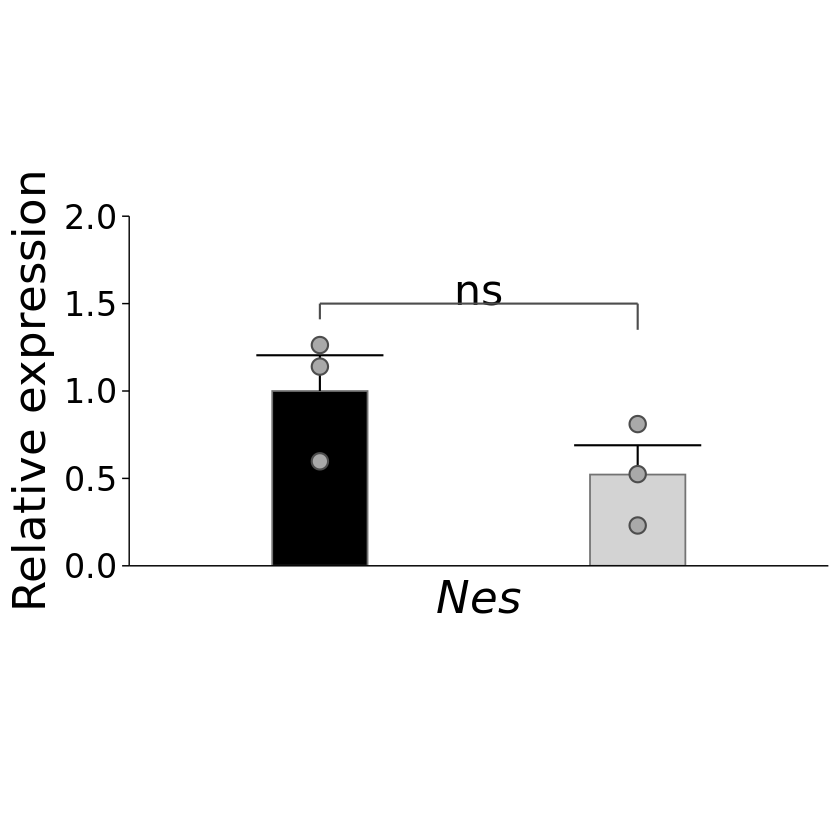

In [10]:
y_sig <- 1.5 # move this OUTSIDE the ggplot

p <- ggplot(plot_data, aes(x = condition, y = relative_expression)) +
    geom_bar(
        data = summary_data,
        aes(x = condition, y = mean_expression, fill = condition),
        stat = "identity",
        width = 0.3,
        color = "grey45",
        linewidth = 0.5,
    ) +
    geom_top_errorbar(summary_data) +
    geom_point(
        color = "grey30", # fixed black outline
        fill = "darkgrey", # fixed grey fill
        shape = 21, size = 4.0, stroke = 0.9
    ) +
    scale_fill_manual(values = c("WT" = "black", "R270X" = "lightgray")) +

    # significance label and lines (inside the ggplot chain)
    annotate("text", x = 1.5, y = y_sig + 0.08, label = significance_label, size = 9) +
    annotate("segment", x = 1, xend = 2, y = y_sig, yend = y_sig, color = "grey30", linewidth = 0.6) +
    annotate("segment", x = 1, xend = 1, y = y_sig, yend = y_sig - 0.09, color = "grey30", linewidth = 0.6) +
    annotate("segment", x = 2, xend = 2, y = y_sig, yend = y_sig - 0.15, color = "grey30", linewidth = 0.6) +
    labs(x = expression(italic("Nes")), y = "Relative expression") +
    scale_y_continuous(limits = c(0, 2.0), breaks = seq(0, 2, 0.5), expand = c(0, 0)) +
    theme_minimal(base_size = 14) +
    theme(
        axis.line = element_line(color = "black", linewidth = 0.4),
        panel.grid = element_blank(),
        panel.background = element_rect(fill = "white", color = NA),
        plot.background = element_rect(fill = "white", color = NA),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_line(color = "black", linewidth = 0.4),
        axis.ticks.length.y = unit(0.15, "cm"),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 20, color = "black"),
        axis.title.x = element_text(face = "italic", size = 27, color = "black", margin = margin(t = 5)),
        axis.title.y = element_text(size = 27, margin = margin(r = 10), color = "black"),
        legend.position = "inside",
        legend.position.inside = c(1.3, 0.9),
        legend.title = element_blank(),
        legend.text = element_text(size = 13, color = "black"),
        legend.background = element_rect(fill = "white", color = NA),
        legend.key = element_rect(fill = "white", color = NA),
        legend.box = "vertical",
        legend.box.spacing = unit(0.2, "cm"),
        legend.key.spacing.y = unit(0.3, "cm"),
        legend.margin = margin(t = 5, b = 5),
        # plot.margin = unit(c(0.5, 0.5, 0.1, 0.5), "cm"),
        aspect.ratio = 0.5
    ) +
    guides(
        fill = guide_legend(
            override.aes = list(
                shape = 22,
                size = 5,
                color = "grey30"
            ),
            keywidth = unit(1.1, "cm"),
            keyheight = unit(0.4, "cm"),
            byrow = TRUE # Ensures items are arranged in rows, helpful for spacing
        )
    )

# Show the plot
print(p)


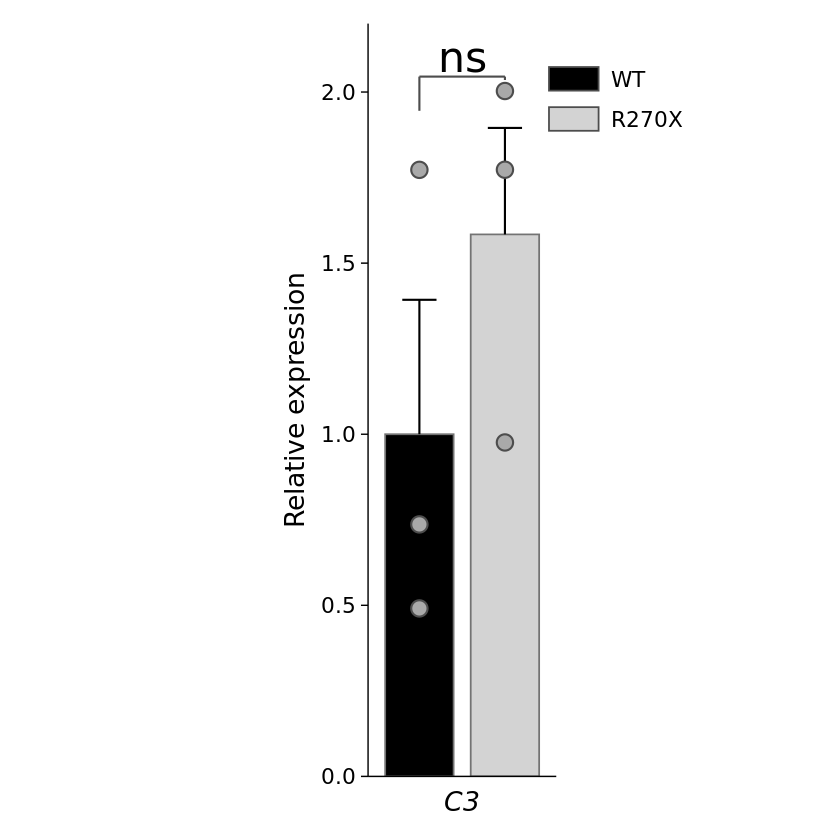

In [11]:
# Define gene ID for C3
c3_ensg_id <- "ENSG00000125730"

if (!(c3_ensg_id %in% rownames(dds))) {
    stop("C3 gene not found.")
}

# Extract normalized counts
c3_counts <- as.numeric(counts(dds, normalized = TRUE)[c3_ensg_id, ])
sample_data <- as.data.frame(colData(dds))

# Combine into plot_data
plot_data <- data.frame(
    condition = sample_data$condition,
    expression = c3_counts
)

# Normalize to WT
wt_mean <- mean(plot_data$expression[plot_data$condition == "WT"])
plot_data$relative_expression <- plot_data$expression / wt_mean

# Summary stats
summary_data <- plot_data %>%
    group_by(condition) %>%
    summarise(
        mean_expression = mean(relative_expression),
        se_expression = sd(relative_expression) / sqrt(n())
    ) %>%
    mutate(
        x_numeric = as.numeric(factor(condition)),
        y_top = mean_expression + se_expression
    )

# T-test
t_test_result <- t.test(relative_expression ~ condition, data = plot_data)
p_value <- t_test_result$p.value
significance_label <- ifelse(p_value < 0.001, "***",
    ifelse(p_value < 0.05, "*", "ns")
)

# Significance line position
y_sig <- max(summary_data$y_top) + 0.15

# Plot
p_c3 <- ggplot(plot_data, aes(x = condition, y = relative_expression)) +
    geom_bar(
        data = summary_data,
        aes(y = mean_expression, fill = condition),
        stat = "identity",
        width = 0.8,
        color = "grey45",
        linewidth = 0.5
    ) +
    geom_top_errorbar(summary_data) +
    geom_point(
        color = "grey30",
        fill = "darkgrey",
        shape = 21, size = 4.0, stroke = 0.9
    ) +
    scale_fill_manual(values = c("WT" = "black", "R270X" = "lightgray")) +
    annotate("text", x = 1.5, y = y_sig + 0.06, label = significance_label, size = 9) +
    annotate("segment", x = 1, xend = 2, y = y_sig, yend = y_sig, color = "grey30", linewidth = 0.6) +
    annotate("segment", x = 1, xend = 1, y = y_sig, yend = y_sig - 0.1, color = "grey30", linewidth = 0.6) +
    annotate("segment", x = 2, xend = 2, y = y_sig, yend = y_sig - 0.01, color = "grey30", linewidth = 0.6) +
    labs(x = expression(italic("C3")), y = "Relative expression") +
    scale_y_continuous(limits = c(0, 2.2), breaks = seq(0, 2.2, 0.5), expand = c(0, 0)) +
    theme_minimal(base_size = 14) +
    theme(
        axis.line = element_line(color = "black", linewidth = 0.4),
        panel.grid = element_blank(),
        panel.background = element_rect(fill = "white", color = NA),
        plot.background = element_rect(fill = "white", color = NA),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_line(color = "black", linewidth = 0.4),
        axis.ticks.length.y = unit(0.15, "cm"),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 13, color = "black"),
        axis.title.x = element_text(face = "italic", size = 16, color = "black", margin = margin(t = 5)),
        axis.title.y = element_text(size = 16, margin = margin(r = 10), color = "black"),
        legend.position = "inside",
        legend.position.inside = c(1.3, 0.9),
        legend.title = element_blank(),
        legend.text = element_text(size = 13, color = "black"),
        legend.background = element_rect(fill = "white", color = NA),
        legend.key = element_rect(fill = "white", color = NA),
        legend.box = "vertical",
        legend.box.spacing = unit(0.2, "cm"),
        legend.key.spacing.y = unit(0.3, "cm"),
        legend.margin = margin(t = 5, b = 5),
        plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm"),
        aspect.ratio = 4 / 1
    ) +
    guides(
        fill = guide_legend(
            override.aes = list(shape = 22, size = 5, color = "grey30"),
            keywidth = unit(1.1, "cm"),
            keyheight = unit(0.4, "cm"),
            byrow = TRUE
        )
    )

print(p_c3)


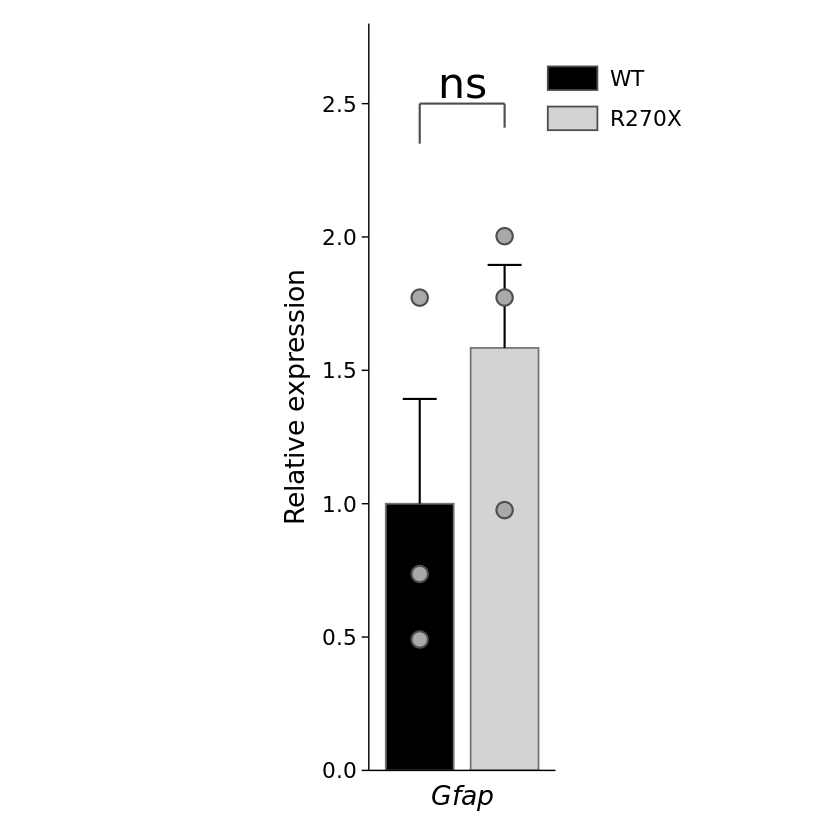

In [12]:
# Set y-axis annotation level
y_sig <- 2.5 # just above R270X top

p_gfap <- ggplot(plot_data, aes(x = condition, y = relative_expression)) +
    geom_bar(
        data = summary_data,
        aes(x = condition, y = mean_expression, fill = condition),
        stat = "identity",
        width = 0.8,
        color = "grey45",
        linewidth = 0.5
    ) +
    geom_top_errorbar(summary_data) +
    geom_point(
        color = "grey30",
        fill = "darkgrey",
        shape = 21, size = 4.0, stroke = 0.9
    ) +
    scale_fill_manual(values = c("WT" = "black", "R270X" = "lightgray")) +

    # Significance annotation for GFAP
    annotate("text", x = 1.5, y = y_sig + 0.08, label = significance_label, size = 9) +
    annotate("segment", x = 1, xend = 2, y = y_sig, yend = y_sig, color = "grey30", linewidth = 0.6) +
    annotate("segment", x = 1, xend = 1, y = y_sig, yend = y_sig - 0.15, color = "grey30", linewidth = 0.6) +
    annotate("segment", x = 2, xend = 2, y = y_sig, yend = y_sig - 0.09, color = "grey30", linewidth = 0.6) +
    labs(x = expression(italic("Gfap")), y = "Relative expression") +
    scale_y_continuous(limits = c(0, 2.8), breaks = seq(0, 2.5, 0.5), expand = c(0, 0)) +
    theme_minimal(base_size = 14) +
    theme(
        axis.line = element_line(color = "black", linewidth = 0.4),
        panel.grid = element_blank(),
        panel.background = element_rect(fill = "white", color = NA),
        plot.background = element_rect(fill = "white", color = NA),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_line(color = "black", linewidth = 0.4),
        axis.ticks.length.y = unit(0.15, "cm"),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 13, color = "black"),
        axis.title.x = element_text(face = "italic", size = 16, color = "black", margin = margin(t = 5)),
        axis.title.y = element_text(size = 16, margin = margin(r = 10), color = "black"),
        legend.position = "inside",
        legend.position.inside = c(1.3, 0.9),
        legend.title = element_blank(),
        legend.text = element_text(size = 13, color = "black"),
        legend.background = element_rect(fill = "white", color = NA),
        legend.key = element_rect(fill = "white", color = NA),
        legend.box = "vertical",
        legend.box.spacing = unit(0.2, "cm"),
        legend.key.spacing.y = unit(0.3, "cm"),
        legend.margin = margin(t = 5, b = 5),
        plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm"),
        aspect.ratio = 4 / 1
    ) +
    guides(
        fill = guide_legend(
            override.aes = list(
                shape = 22,
                size = 5,
                color = "grey30"
            ),
            keywidth = unit(1.1, "cm"),
            keyheight = unit(0.4, "cm"),
            byrow = TRUE
        )
    )

print(p_gfap)


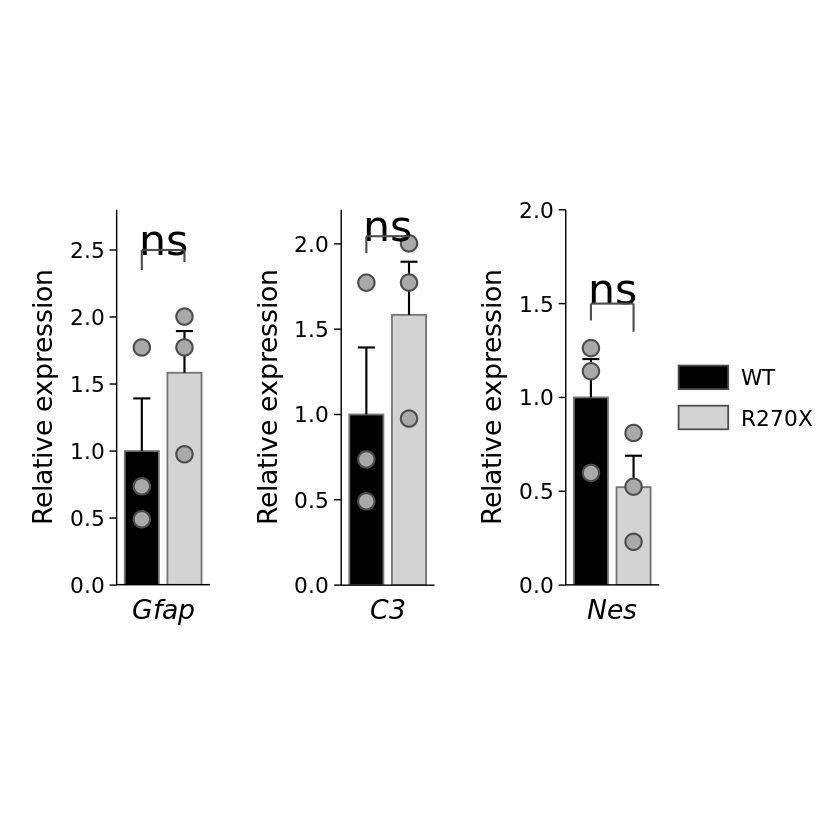

In [15]:
library(patchwork)
combined_plot <- p_gfap + p_c3 + p_nes +
    plot_layout(ncol = 3, guides = "collect") & theme(legend.position = "right")

combined_plot


In [19]:
# Define GFAP gene ENSG ID
gfap_ensg_id <- "ENSG00000131095" # replace if needed

# Check existence
if (!(gfap_ensg_id %in% rownames(dds))) {
    stop("GFAP gene not found in dataset.")
}

# Extract normalized counts
gfap_counts <- as.numeric(counts(dds, normalized = TRUE)[gfap_ensg_id, ])
sample_data <- as.data.frame(colData(dds))

# Combine into one dataframe
plot_data <- data.frame(
    condition = sample_data$condition,
    expression = gfap_counts
)

# Normalize to WT mean
wt_mean <- mean(plot_data$expression[plot_data$condition == "WT"])
plot_data$relative_expression <- plot_data$expression / wt_mean

# Summary stats for bar height and error bars
summary_data <- plot_data %>%
    group_by(condition) %>%
    summarise(
        mean_expression = mean(relative_expression),
        se_expression = sd(relative_expression) / sqrt(n())
    ) %>%
    mutate(y_top = mean_expression + se_expression)

# Significance test
t_test_result <- t.test(relative_expression ~ condition, data = plot_data)
p_value <- t_test_result$p.value
significance_label <- ifelse(p_value < 0.001, "***",
    ifelse(p_value < 0.05, "*", "ns")
)

# y-position for significance annotation
y_sig <- max(summary_data$y_top) + 0.15

# Final ggplot for GFAP
p_gfap <- ggplot(plot_data, aes(x = condition, y = relative_expression)) +
    geom_bar(
        data = summary_data,
        aes(y = mean_expression, fill = condition),
        stat = "identity",
        width = 0.8,
        color = "grey45",
        linewidth = 0.5
    ) +
    geom_top_errorbar(summary_data) +
    geom_point(
        color = "grey30",
        fill = "darkgrey",
        shape = 21, size = 4.0, stroke = 0.9
    ) +
    scale_fill_manual(values = c("WT" = "black", "R270X" = "lightgray")) +
    annotate("text", x = 1.5, y = y_sig + 0.08, label = significance_label, size = 9) +
    annotate("segment", x = 1, xend = 2, y = y_sig, yend = y_sig, color = "grey30", linewidth = 0.6) +
    annotate("segment", x = 1, xend = 1, y = y_sig, yend = y_sig - 0.15, color = "grey30", linewidth = 0.6) +
    annotate("segment", x = 2, xend = 2, y = y_sig, yend = y_sig - 0.09, color = "grey30", linewidth = 0.6) +
    labs(x = expression(italic("Gfap")), y = "Relative expression") +
    scale_y_continuous(limits = c(0, 2.8), breaks = seq(0, 2.5, 0.5), expand = c(0, 0)) +
    theme_minimal(base_size = 14) +
    theme(
        axis.line = element_line(color = "black", linewidth = 0.4),
        panel.grid = element_blank(),
        panel.background = element_rect(fill = "white", color = NA),
        plot.background = element_rect(fill = "white", color = NA),
        axis.ticks.x = element_blank(),
        axis.ticks.y = element_line(color = "black", linewidth = 0.4),
        axis.ticks.length.y = unit(0.15, "cm"),
        axis.text.x = element_blank(),
        axis.text.y = element_text(size = 13, color = "black"),
        axis.title.x = element_text(face = "italic", size = 16, color = "black", margin = margin(t = 5)),
        axis.title.y = element_text(size = 16, margin = margin(r = 10), color = "black"),
        legend.position = "inside",
        legend.position.inside = c(1.3, 0.9),
        legend.title = element_blank(),
        legend.text = element_text(size = 13, color = "black"),
        legend.background = element_rect(fill = "white", color = NA),
        legend.key = element_rect(fill = "white", color = NA),
        legend.box = "vertical",
        legend.box.spacing = unit(0.2, "cm"),
        legend.key.spacing.y = unit(0.3, "cm"),
        legend.margin = margin(t = 5, b = 5),
        plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm"),
        aspect.ratio = 4 / 1
    ) +
    guides(
        fill = guide_legend(
            override.aes = list(shape = 22, size = 5, color = "grey30"),
            keywidth = unit(1.1, "cm"),
            keyheight = unit(0.4, "cm"),
            byrow = TRUE
        )
    )

# Show it
print(p_gfap)


ERROR: [1m[33mError[39m in `geom_segment()`:[22m
[1m[22m[33m![39m Problem while computing aesthetics.
[36mℹ[39m Error occurred in the 2nd layer.
[1mCaused by error:[22m
[33m![39m object 'x_numeric' not found


In [16]:
ggsave(
    filename = "combined_plot_proportional_adjusted.png",
    plot = combined_plot,
    width = 18, # A larger total width to accommodate the proportions
    height = 7,
    units = "in",
    dpi = 300
)
